# Easy Neural Network implementation on the cloud using ML Workbench and Datalab

This notebook demonstrate how to use ML Workbench to create a neural network model that reproduces results from the paper
[Determining the Number of
Real Roots of Polynomials
through Neural Networks](http://www.math.upatras.gr/~npav/papers/MourrainPTV_CMA2005.pdf). Execution of this notebook requires Google Datalab (see [setup instructions](https://cloud.google.com/datalab/docs/quickstarts)).



# The Data
We first create a dataframe with columns consisting of the coefficients together with a last column which is 0 or 1 depending on whether or not the polynomial determined by the coefficients in that row has no or two real roots, respectively. 

In [2]:
import numpy as np
import pandas as pd
from itertools import product

In [3]:
def make_coeff(j,k, degree):
    coefficients = list(product(range(j,k+1), repeat = degree + 1 ))
    return coefficients

The function below counts the real roots of a polynomial `p` using the discriminant.

In [4]:
def count_real_roots(p):
  ''' For given triple p of coefficients of a quadratic polynomial,
  return 1 if polynomial has two real roots and 0 if no real roots'''
  real_roots = 0
  disc = p[1]**2 - 4 * p[2]* p[0]
  if disc > 0:
    real_roots = 1
  return real_roots

Then we create a list of all possible coefficients of degree 2 polynomials when the coefficients range from 1 to 100. In the dataset used in the paper we are reproducing they used 1 to 10.

In [5]:
coefficients = make_coeff(1,10,2)
data_1_10_2 = [(p[0],p[1], p[2], count_real_roots(p)) for p in coefficients] 
df_1_10_2 = pd.DataFrame(data_1_10_2, columns = ['a0', 'a1', 'a2', 'rr_count'])

In [6]:
df_1_10_2

,a0,a1,a2,rr_count
0,1,1,1,0
1,1,1,2,0
2,1,1,3,0
3,1,1,4,0
4,1,1,5,0
5,1,1,6,0
6,1,1,7,0
7,1,1,8,0
8,1,1,9,0
9,1,1,10,0


So we see that there are 1000 polynomials in our dataframe. Next we look at how many of them have two real roots by summing the `rr_count` column.

In [11]:
sum(df_1_10_2.iloc[:,3])

206

In [104]:
len(df_1_10_2)

1000

Next we sample $0.30\%$ of the data, as this is the proportion used in loc. cit. and we split it into train/eval set.

In [215]:
train_df = df_1_10_2.sample(frac=0.7, replace=False)
#.all(axis) - axis : {0, 1}. 0 for row-wise,
eval_df = df_1_10_2[~df_1_10_2.isin(train_df).all(1)]

In [216]:
len(eval_df)

300

In [217]:
print('Training set includes %d instances.' % len(train_df))
print('Eval set includes %d instances.' % len(eval_df))

Training set includes 700 instances.
Eval set includes 300 instances.


## Save Data

Make a folder to save to and save the data for model training.

In [8]:
!mkdir -p ./data

In [218]:
train_df.to_csv('./data/train-1-10-2.csv', header=False, index=False)
eval_df.to_csv('./data/eval-1-10-2.csv', header=False, index=False)

# Create Model with ML Workbench

The MLWorkbench Magics are a set of Datalab commands that allow an easy code-free experience to training, deploying, and predicting ML models. The MLWorkbench Magics are a collection of magic commands for each step in ML workflows: analyzing input data to build transforms, transforming data, training a model, evaluating a model, and deploying a model.

For details of each command, run with --help. For example, "%%ml train --help".

When the dataset is small, there is little benefit of using cloud services. This notebook will run the analyze, transform, and training steps locally. However, every MLWorkbench magic can run locally or use cloud services by simply adding the --cloud flag.

The next command loads the cell magic %%ml commands for ML Workbench commands.

In [2]:
import google.datalab.contrib.mlworkbench.commands

The following %%ml command opens the help menu for the `dataset create` command.

In [15]:
%%ml dataset create --help

usage: %ml dataset create [-h] --name NAME --format {csv,bigquery,transformed}
                          --train TRAIN --eval EVAL

optional arguments:
  -h, --help            show this help message and exit
  --name NAME           the name of the dataset to define. 
  --format {csv,bigquery,transformed}
                        The format of the data.
  --train TRAIN         The path of the training file pattern if format is csv or transformed, or table name if format is bigquery.
  --eval EVAL           The path of the eval file pattern if format is csv or transformed, or table name if format is bigquery.

Cell args:

schema: Optional. yaml representation of CSV schema, or path to schema file. Only needed if format is csv..

Example usage:

%%ml dataset
name: mydata
format: csv
train: path/to/train.csv
eval: path/to/eval.csv
schema:
  - name: news_label
    type: STRING
  - name: text
    type: STRING



## Step 1: Create

The first step in the MLWorkbench workflow is to `create` the dataset which prepares the dataset in a format needed by ML Workbench for training.

In [11]:
%%ml dataset create
format: csv
train: ./data/
eval: ./data/eval-1-10-train-1-10-2.csv2.csv
name: real_roots-1-10-2
schema:
    - name: a0
      type: FLOAT
    - name: a1
      type: FLOAT
    - name: a2
      type: FLOAT
    - name: rr_count
      type: STRING

## Step 2: Analyze

The next step in the MLWorkbench workflow is to analyze the data for the requested transformations. Analysis in this case builds vocabulary for categorical features, and compute numeric stats for numeric features.

In [15]:
!rm -r -f ./data/analysis # Delete previous run results.

In [16]:
%%ml analyze --help

usage: %ml analyze [-h] --output OUTPUT [--cloud] [--package PACKAGE]

Analyze training data and generate stats, such as min/max/mean for numeric values, vocabulary for text columns.

optional arguments:
  -h, --help         show this help message and exit
  --output OUTPUT    path of output directory.
  --cloud            whether to run analysis in cloud or local.
  --package PACKAGE  A local or GCS tarball path to use as the source. If not set, the default source package will be used.

Cell args:

data: Required. Training data. A dataset defined by "%%ml dataset"..

features: Required. features config indicating how to transform data into features. The
list of supported transforms:
    "transform: identity"
         does nothing (for numerical columns).
    "transform: scale
     value: x"
         scale a numerical column to [-a, a]. If value is missing, x
         defaults to 1.
    "transform: one_hot"
         treats the string column as categorical and makes one-hot
         enc

Now we use `analyze` on our dataset and set the target to `rr_count` in order to prepare for the next step of training.

In [12]:
%%ml analyze
output: ./data/analysis
data: $real_roots-1-10-2
features:
  a0:
    transform: identity
  a1:
    transform: identity   
  a2:
    transform: identity
  rr_count:
    transform: target

Expanding any file patterns...
file list computed.
Analyzing file /content/datalab/notebooks/real-roots/data/train-1-10-2.csv...
file /content/datalab/notebooks/real-roots/data/train-1-10-2.csv analyzed.


Note in the above "features" config, "target" is required and has to be specified explicitly. 

## Step 2: Training

MLWorkbench help build standard TensorFlow models without you having to write any TensorFlow code. 

In [7]:
# Delete previous run results.
!rm -r -f ./data/dnn_train 

### NN Model
The model we construct is a simple fully-connected feedforward neural network with two hidden layers having 8 and 7 hidden units respectively. This was chosen to match the model in loc. cit.

The training will run until it detects eval loss is no longer decreasing, or hits number of epochs limit (1000). For more details on the model `dnn_classification`, see http://googledatalab.github.io/pydatalab/mltoolbox.classification.dnn.html
For more details on how this model is trained, see https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer

In [18]:
%%ml train --help

usage: %ml train [-h] --analysis ANALYSIS --output OUTPUT [--cloud]
                 [--package PACKAGE]

Train a model.

optional arguments:
  -h, --help           show this help message and exit
  --analysis ANALYSIS  path of analysis output directory.
  --output OUTPUT      path of trained model directory.
  --cloud              whether to run training in cloud or local.
  --package PACKAGE    A local or GCS tarball path to use as the source. If not set, the default source package will be used.

Cell args:

cloud_config: Optional. A dictionary of cloud training config, including:
    job_id: the name of the job. If not provided, a default job name is created.
    region: see https://cloud.google.com/sdk/gcloud/reference/ml-engine/jobs/submit/training
    runtime_version: see "region". Must be a string like '1.2'.
    scale_tier: see "region"..

data: Required. Training data. A dataset defined by "%%ml dataset"..

model_args: Optional. model_args: a dictionary of model specific args,

Now we train our model, specifying the number of hidden layers and number of hidden units. We follow loc. cit. in using 8 hidden units in the first hidden layer and 7 in the second hidden layer. The `dnn_classification` model is a feedforward neural network model where the loss function is softmax cross entropy and tensorflow's `tf.train.AdamOptimizer` is used to find the weights. See [here](http://googledatalab.github.io/pydatalab/mltoolbox.classification.dnn.html) for the ML Workbench documentation. Note the TensorBoard link will not work unless you are running this notebook in Datalab.

In [14]:
%%ml train
output: ./data/dnn_train
analysis: ./data/analysis
data: $real_roots-1-10-2
model_args:
    model: dnn_classification
    hidden-layer-size1: 8
    hidden-layer-size2: 7

TensorBoard was started successfully with pid 191. Click here to access it.

We can also plot the summary events which will be saved with the notebook using the `Summary` module.

In [15]:
from google.datalab.ml import Summary

In [16]:
help(Summary)

Help on class Summary in module google.datalab.ml._summary:

class Summary(__builtin__.object)
 |  Represents TensorFlow summary events from files under specified directories.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, paths)
 |      Initializes an instance of a Summary.
 |      Args:
 |        path: a path or a list of paths to directories which hold TensorFlow events files.
 |              Can be local path or GCS paths. Wild cards allowed.
 |  
 |  get_events(self, event_names)
 |      Get all events as pandas DataFrames given a list of names.
 |      Args:
 |        event_names: A list of events to get.
 |      Returns:
 |        A list with the same length and order as event_names. Each element is a dictionary
 |            {dir1: DataFrame1, dir2: DataFrame2, ...}.
 |            Multiple directories may contain events with the same name, but they are different
 |            events (i.e. 'loss' under trains_set/, and 'loss' under eval_set/.)
 |  
 |  list_events(self)


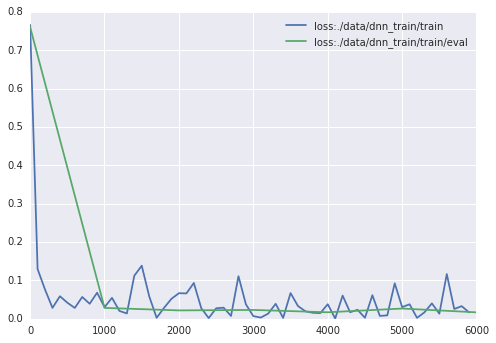

In [17]:
summary = Summary('./data/dnn_train')
summary.plot('loss')

## Step 4: Evaluation 

If you want to delete previous evaluation results the next line uses bash code to force remove the folder containing the eval results.

In [18]:
!rm -r -f ./data/batch_predict_10

There are two model dirs under our training dir: "evaluation_model" and "model". The difference between these two is that evaluation model expects input with target (truth) value, while regular model expects no target column. Evaluation model outputs the input target value as is. Because it outputs both target and predicted value, it is good for model evaluation.

In [260]:
!ls ./data/batch_predict_10

predict_results_eval-1-10-2.csv  predict_results_schema.json


In [19]:
%%ml batch_predict
model: ./data/dnn_train/evaluation_model/
output: ./data/batch_predict_10
format: csv
batch_size: 20
data:
  csv: ./data/eval-1-10-2.csv    

local prediction...
INFO:tensorflow:Restoring parameters from ./data/dnn_train/evaluation_model/variables/variables
done.


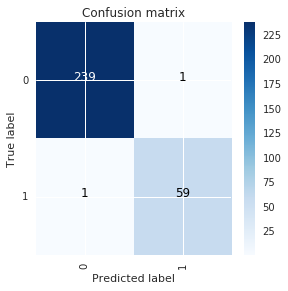

In [20]:
%%ml evaluate confusion_matrix --plot --size 4
csv: ./data/batch_predict_10/predict_results_eval-1-10-2.csv

In [12]:
%%ml evaluate accuracy
csv: ./data/batch_predict_10/predict_results_eval-1-10-2.csv

,accuracy,count,target
0,0.995833,240,0
1,0.983333,60,1
2,0.993333,300,_all


In [15]:
%%ml evaluate roc --plot
target_class: 0
csv: ./data/batch_predict_10/predict_results_eval-1-10-2.csv


Cannot find "target" or "0" column

# Prediction

The MLWorkbench supports running prediction and displaying the results within the notebook.

## Local Prediction

Note that now we use the non-evaluation model below (./dnn_train/model) which takes input with no target column. The prediction data is taken from eval csv file with target column removed.

In [22]:
%%ml predict
model: ./data/dnn_train/model/
data:
  - 1,2,8
  - 1,4,5
  - 1,8,1

predicted,probability,a0,a1,a2
0,1.0000,1,2,8
0,0.9679,1,4,5
1,1.0000,1,8,1
